In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BiomarkerDataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)  # Empty clinical data

        return images, labels, clinical_data


# Define Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output


# Initialize Dataset and Transformers
image_size = 224
mean, std = 0.1706, 0.2112

# Train transform with data augmentation
train_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform without augmentation
test_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)

# Initialize Models
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)


# Training Loop
def train_model(model, loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for images, labels, clinical_data in tqdm(loader):
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            optimizer.zero_grad()
            outputs = model(images, clinical_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses


# Train vision-only model
optimizer_no_clinical = optim.Adam(model_no_clinical.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train_losses_no_clinical = train_model(
    model_no_clinical, trainloader_no_clinical, optimizer_no_clinical, criterion, epochs=10
)

# Initialize multimodal model with pretrained vision weights
model_clinical.vision_model.load_state_dict(model_no_clinical.vision_model.state_dict())

# Freeze vision model weights
for param in model_clinical.vision_model.parameters():
    param.requires_grad = False

# Unfreeze fusion layers
for param in model_clinical.clinical_fc.parameters():
    param.requires_grad = True
for param in model_clinical.combined_fc.parameters():
    param.requires_grad = True

# Optimizer for fusion layers
optimizer_clinical_fusion = optim.Adam(
    list(model_clinical.clinical_fc.parameters()) + list(model_clinical.combined_fc.parameters()), lr=1e-4
)

# Train multimodal model (fusion layers only)
train_losses_clinical_fusion = train_model(
    model_clinical, trainloader_clinical, optimizer_clinical_fusion, criterion, epochs=10
)


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:14: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:64: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Epoch 1/10, Loss: 0.2478


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 2/10, Loss: 0.1773


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 3/10, Loss: 0.1487


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 4/10, Loss: 0.1277


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 5/10, Loss: 0.1087


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 6/10, Loss: 0.0984


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 7/10, Loss: 0.0880


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 8/10, Loss: 0.0809


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch 9/10, Loss: 0.0759


100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 10/10, Loss: 0.0696


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch 1/10, Loss: 7.3524


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 2/10, Loss: 3.7631


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch 3/10, Loss: 3.7199


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 4/10, Loss: 3.6921


100%|██████████| 111/111 [01:00<00:00,  1.84it/s]


Epoch 5/10, Loss: 3.6819


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 6/10, Loss: 3.6773


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 7/10, Loss: 3.6698


100%|██████████| 111/111 [01:00<00:00,  1.82it/s]


Epoch 8/10, Loss: 3.6674


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 9/10, Loss: 3.6578


100%|██████████| 111/111 [01:00<00:00,  1.82it/s]

Epoch 10/10, Loss: 3.6663


Evaluating Model with Clinical Data...
Evaluating Scan-Level Metrics...
Plotting Combined Confusion Matrix for Scan-Level Predictions...


<Figure size 600x400 with 0 Axes>

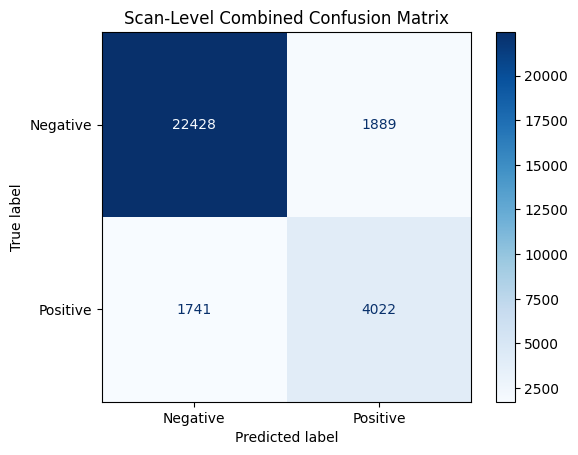

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.725099   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.837405   0.041667  0.013889  0.020833
2                               DRIL  0.743918   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.796862   0.082353  0.092105  0.086957
4                             IR HRF  0.790587   0.875201  0.753292  0.809683
5   Partially attached vitreous face  0.782534   0.658436  0.643432  0.650847
6       Fully attached vitreous face  0.808832   0.733766  0.713684  0.723586
7       Preretinal tissue/hemorrhage  0.722231   1.000000  0.009615  0.019048
8                    Vitreous debris  0.761190   0.632017  0.501650  0.559338
9                                VMT  0.091813   0.000000  0.000000  0.000000
10                            DRT/ME  0.956055   0.935424  0.786047  0.854254
11                       Fluid (IRF)  0.500000   0.507447  1.000

<Figure size 600x400 with 0 Axes>

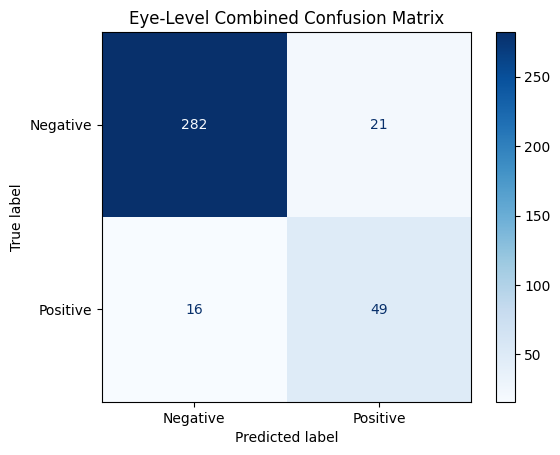

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.545455   0.000000  0.000000  0.000000
1                   Disruption of EZ       NaN   0.000000  0.000000  0.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages       NaN   0.000000  0.000000  0.000000
4                             IR HRF  0.642857   0.944444  0.809524  0.871795
5   Partially attached vitreous face  0.746032   0.555556  0.555556  0.555556
6       Fully attached vitreous face  0.830769   0.666667  0.800000  0.727273
7       Preretinal tissue/hemorrhage       NaN   0.000000  0.000000  0.000000
8                    Vitreous debris  0.688889   0.666667  0.400000  0.500000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  0.991071   1.000000  0.714286  0.833333
11                       Fluid (IRF)  0.500000   0.521739  1.000

<Figure size 600x400 with 0 Axes>

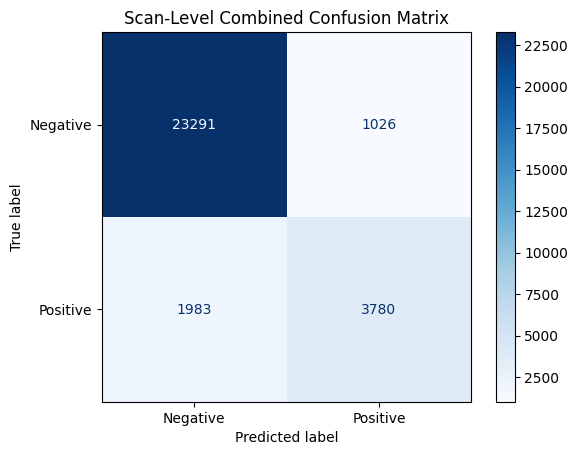

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.678681   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.828548   0.000000  0.000000  0.000000
2                               DRIL  0.177056   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.782282   0.065217  0.039474  0.049180
4                             IR HRF  0.786862   0.880299  0.733888  0.800454
5   Partially attached vitreous face  0.766553   0.674051  0.571046  0.618287
6       Fully attached vitreous face  0.823128   0.723197  0.781053  0.751012
7       Preretinal tissue/hemorrhage  0.709151   1.000000  0.086538  0.159292
8                    Vitreous debris  0.764780   0.611524  0.542904  0.575175
9                                VMT  0.726159   0.000000  0.000000  0.000000
10                            DRT/ME  0.955837   0.909091  0.821705  0.863192
11                       Fluid (IRF)  0.905815   0.909582  0.706

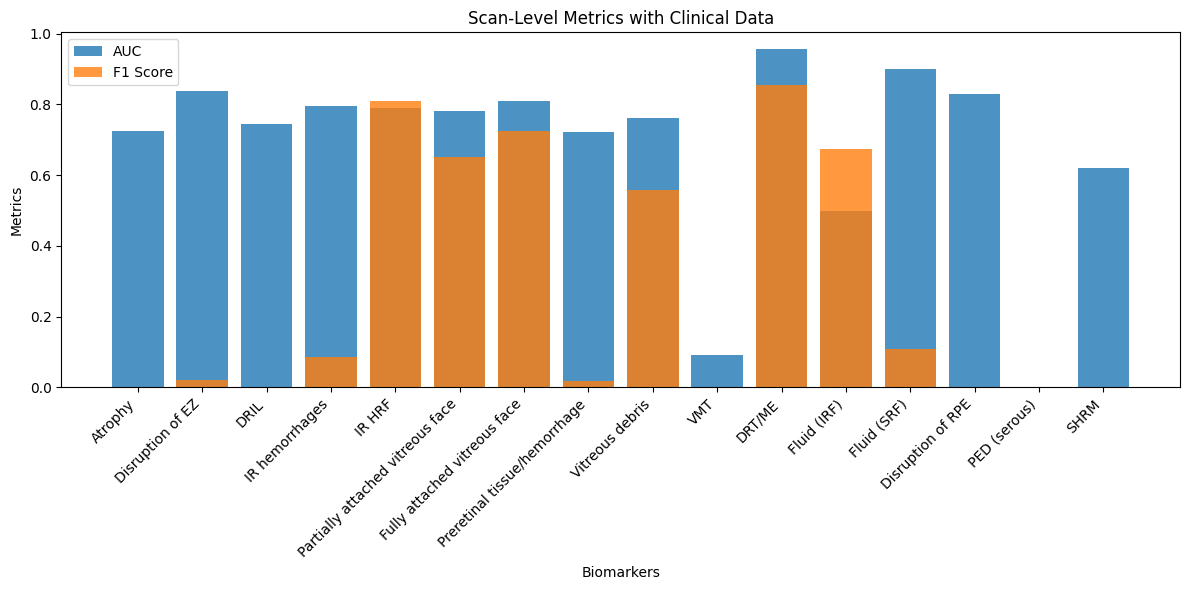

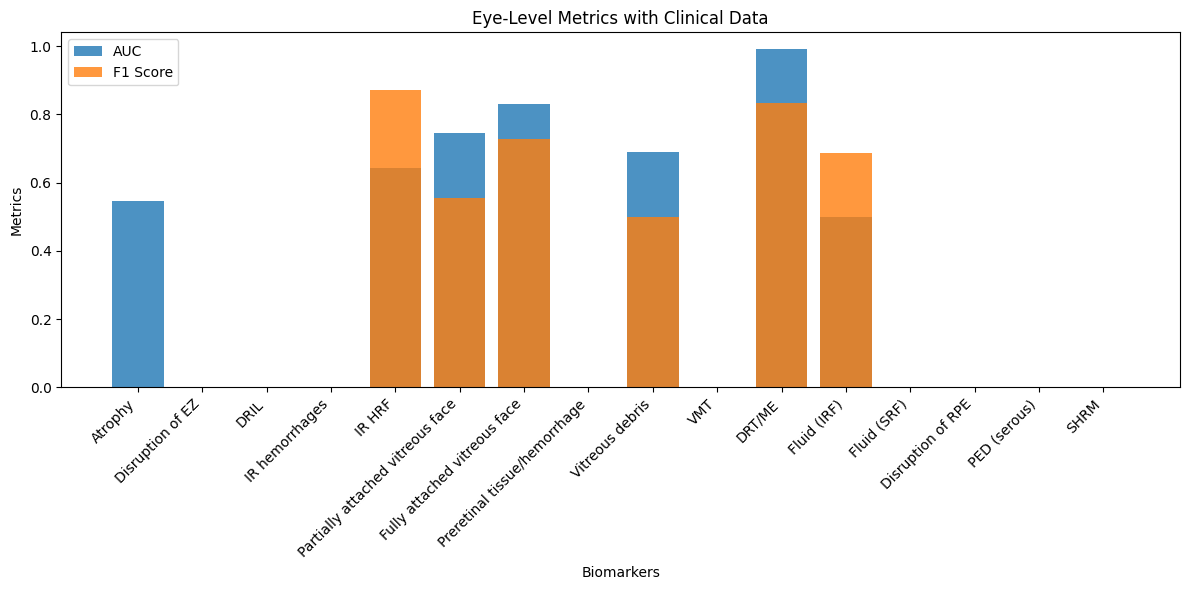

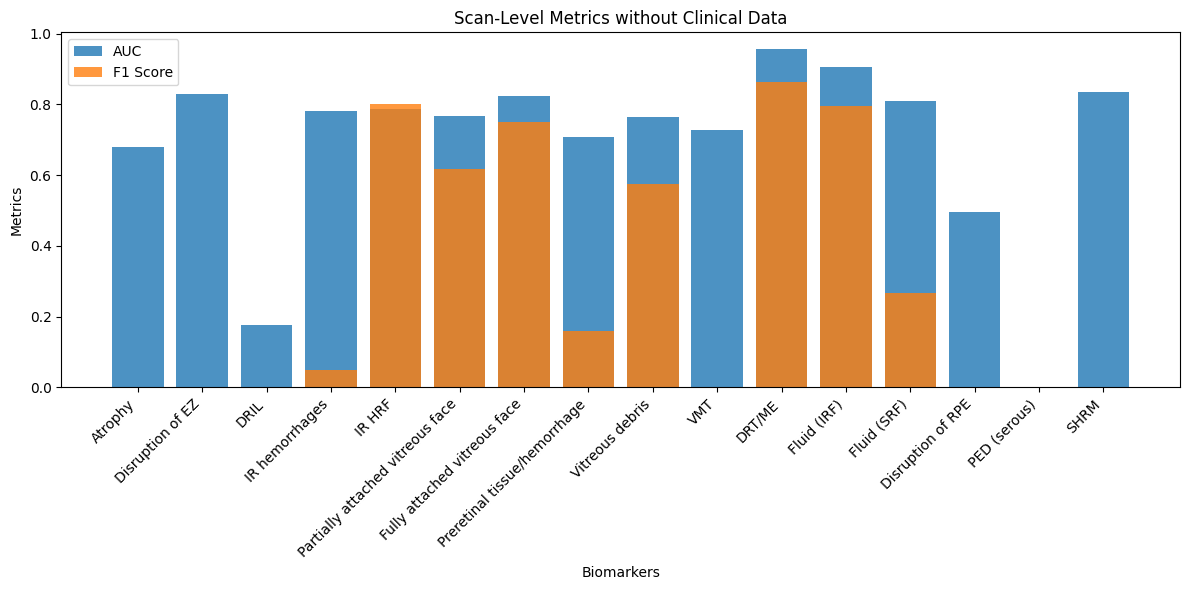


Ablation Study Results:
Clinical Data Impact on Biomarker Detection
                           Biomarker  F1 with Clinical Data  \
0                            Atrophy               0.000000   
1                   Disruption of EZ               0.020833   
2                               DRIL               0.000000   
3                     IR hemorrhages               0.086957   
4                             IR HRF               0.809683   
5   Partially attached vitreous face               0.650847   
6       Fully attached vitreous face               0.723586   
7       Preretinal tissue/hemorrhage               0.019048   
8                    Vitreous debris               0.559338   
9                                VMT               0.000000   
10                            DRT/ME               0.854254   
11                       Fluid (IRF)               0.673253   
12                       Fluid (SRF)               0.109091   
13                 Disruption of RPE             

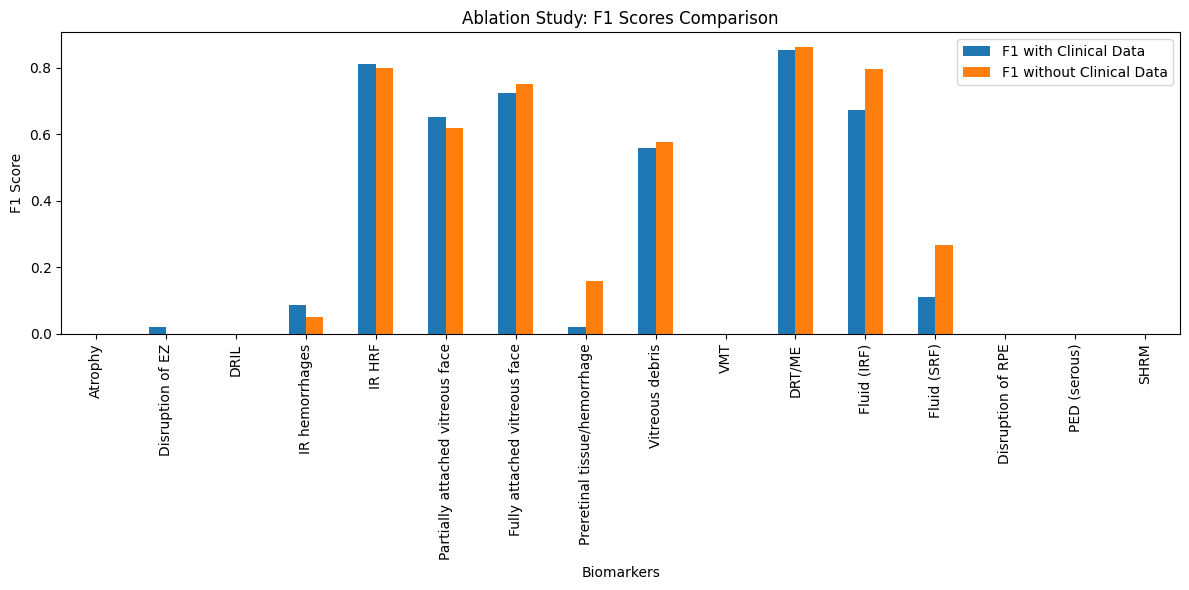

In [2]:
# Evaluation Function
def evaluate_model(model, loader, labels):
    """
    Evaluate the model and calculate metrics at the scan level.
    """
    model.eval()
    y_true, y_pred, eye_ids = [], [], []
    with torch.no_grad():
        for images, labels, clinical_data in loader:
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            outputs = model(images, clinical_data)
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
            if clinical_data.size(1) > 0:  # Ensure Eye_ID exists
                eye_ids.append(clinical_data[:, 0].cpu().numpy())
            else:
                eye_ids.append([])  # No Eye_ID if no clinical data
    return np.vstack(y_true), np.vstack(y_pred), np.concatenate(eye_ids)

# Aggregation Function for Eye-Level Metrics
def aggregate_by_eye(y_true, y_pred, eye_ids):
    """
    Aggregate predictions and labels at the eye level.
    """
    unique_eye_ids = np.unique(eye_ids)
    eye_level_true = []
    eye_level_pred = []
    for eye_id in unique_eye_ids:
        mask = eye_ids == eye_id
        eye_level_true.append(y_true[mask].mean(axis=0))
        eye_level_pred.append(y_pred[mask].mean(axis=0))
    return np.array(eye_level_true), np.array(eye_level_pred)

from sklearn.metrics import roc_auc_score, classification_report

def compute_metrics(y_true, y_pred, labels):
    """
    Compute classification metrics for each biomarker.
    Args:
        y_true (ndarray or Tensor): True labels.
        y_pred (ndarray or Tensor): Predicted probabilities.
        labels (list): Biomarker names.
    Returns:
        metrics_df (DataFrame): DataFrame with per-biomarker metrics.
    """
    # Ensure tensors are moved to CPU and converted to NumPy
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Threshold y_true to ensure binary values
    y_true = (y_true > 0.5).astype(int)

    num_biomarkers = min(len(labels), y_true.shape[1])
    metrics = {"Biomarker": [], "AUC": [], "Precision": [], "Recall": [], "F1": []}

    for i in range(num_biomarkers):
        label = labels[i]

        # Check if y_true contains both classes
        if len(np.unique(y_true[:, i])) < 2:
            # Skip AUC calculation for constant labels
            metrics["Biomarker"].append(label)
            metrics["AUC"].append(None)  # Undefined AUC
            metrics["Precision"].append(0.0)
            metrics["Recall"].append(0.0)
            metrics["F1"].append(0.0)
            continue

        # Calculate metrics
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        report = classification_report(
            y_true[:, i], (y_pred[:, i] > 0.5).astype(int), output_dict=True, zero_division=0
        )
        metrics["Biomarker"].append(label)
        metrics["AUC"].append(auc)
        metrics["Precision"].append(report["1"]["precision"])
        metrics["Recall"].append(report["1"]["recall"])
        metrics["F1"].append(report["1"]["f1-score"])
    return pd.DataFrame(metrics)

# Plotting Metrics
def plot_metrics(metrics_df, title):
    """
    Plot metrics as bar plots.
    """
    plt.figure(figsize=(12, 6))
    x = range(len(metrics_df))
    plt.bar(x, metrics_df["AUC"], label="AUC", alpha=0.8)
    plt.bar(x, metrics_df["F1"], label="F1 Score", alpha=0.8)
    plt.xticks(x, metrics_df["Biomarker"], rotation=45, ha="right")
    plt.xlabel("Biomarkers")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Plot ROC-AUC Curves
def plot_roc_auc_curves(y_true, y_pred, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        if len(np.unique(y_true[:, i])) < 2:
            continue  # Skip biomarkers with no positive samples
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Biomarker Labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
     "PED (serous)", "SHRM"
]

# Function to compute and plot a single confusion matrix for all biomarkers
def plot_combined_confusion_matrix(y_true, y_pred, title="Combined Confusion Matrix"):
    """
    Create and plot a single confusion matrix for all biomarkers.
    Args:
        y_true (ndarray): Ground truth binary labels for all biomarkers.
        y_pred (ndarray): Predicted probabilities for all biomarkers.
        title (str): Title for the confusion matrix plot.
    """
    # Flatten all biomarkers into a single dimension for combined confusion matrix
    y_true_combined = (y_true > 0.5).astype(int).ravel()  # Ensure binary labels
    y_pred_combined = (y_pred > 0.5).astype(int).ravel()  # Threshold predictions

    # Compute confusion matrix
    combined_matrix = confusion_matrix(y_true_combined, y_pred_combined)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


# Update the evaluation function to include combined confusion matrix
# Evaluate and Aggregate Results
def evaluate_with_eye_aggregation(model, loader, labels):
    """
    Evaluate model performance with and without eye-level aggregation.
    """
    print("Evaluating Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader, labels)

    # Compute combined confusion matrix for scan-level predictions
    print("Plotting Combined Confusion Matrix for Scan-Level Predictions...")
    plot_combined_confusion_matrix(y_true, y_pred, "Scan-Level Combined Confusion Matrix")

    # Scan-Level Metrics
    scan_metrics = compute_metrics(y_true, y_pred, labels)
    print(scan_metrics)

    # Eye-Level Metrics
    eye_metrics = None
    if len(eye_ids) > 0:
        print("Evaluating Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)

        # Compute combined confusion matrix for eye-level predictions
        print("Plotting Combined Confusion Matrix for Eye-Level Predictions...")
        plot_combined_confusion_matrix(eye_true, eye_pred, "Eye-Level Combined Confusion Matrix")

        eye_metrics = compute_metrics(eye_true, eye_pred, labels)
        print(eye_metrics)

    return scan_metrics, eye_metrics


# Evaluate Models

print("Evaluating Model with Clinical Data...")
scan_metrics_clinical, eye_metrics_clinical = evaluate_with_eye_aggregation(
    model_clinical, testloader_clinical, labels
)

print("Evaluating Model without Clinical Data...")
scan_metrics_no_clinical, eye_metrics_no_clinical = evaluate_with_eye_aggregation(
    model_no_clinical, testloader_no_clinical, labels
)

# Plot Results
plot_metrics(scan_metrics_clinical, "Scan-Level Metrics with Clinical Data")
if eye_metrics_clinical is not None:
    plot_metrics(eye_metrics_clinical, "Eye-Level Metrics with Clinical Data")

plot_metrics(scan_metrics_no_clinical, "Scan-Level Metrics without Clinical Data")
if eye_metrics_no_clinical is not None:
    plot_metrics(eye_metrics_no_clinical, "Eye-Level Metrics without Clinical Data")

# Ablation Study
print("\nAblation Study Results:")
print("Clinical Data Impact on Biomarker Detection")
comparison = pd.DataFrame({
    "Biomarker": labels,
    "F1 with Clinical Data": scan_metrics_clinical["F1"],
    "F1 without Clinical Data": scan_metrics_no_clinical["F1"],
})
print(comparison)
comparison.plot(x="Biomarker", kind="bar", figsize=(12, 6), title="Ablation Study: F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

Evaluating Model with Clinical Data...
Evaluating Model without Clinical Data...
Visualizing biomarker correlations with clinical data...


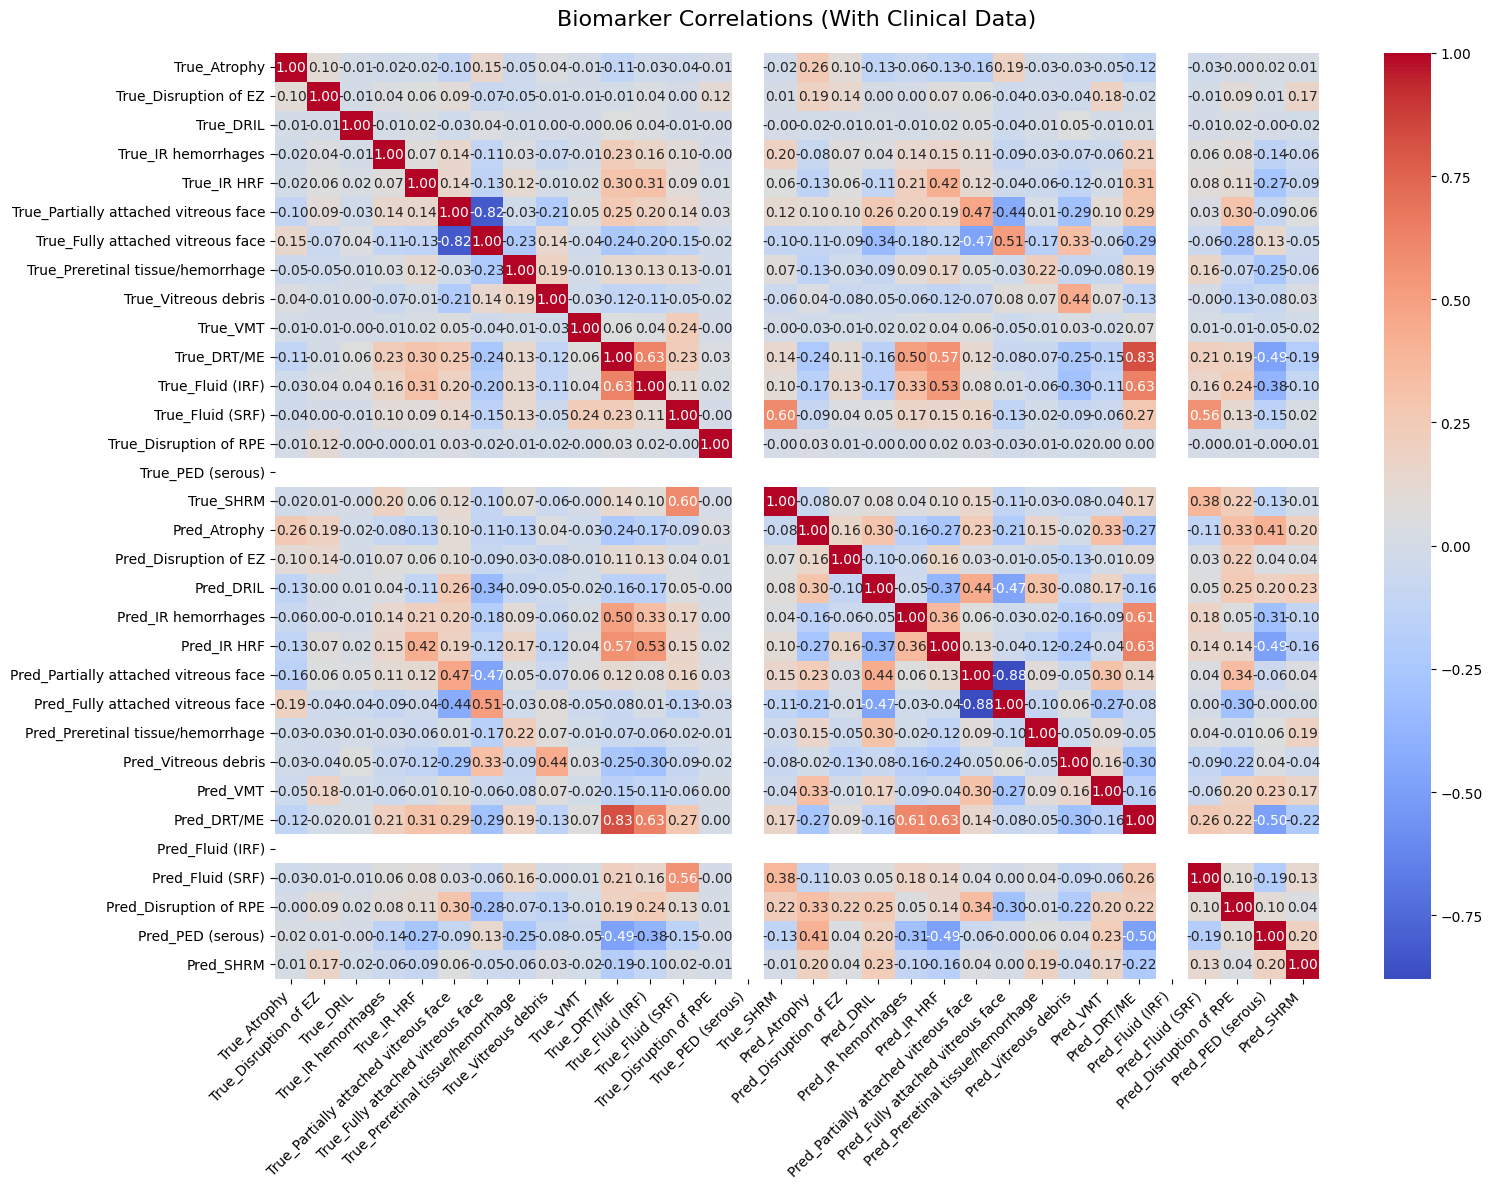

Visualizing biomarker correlations without clinical data...


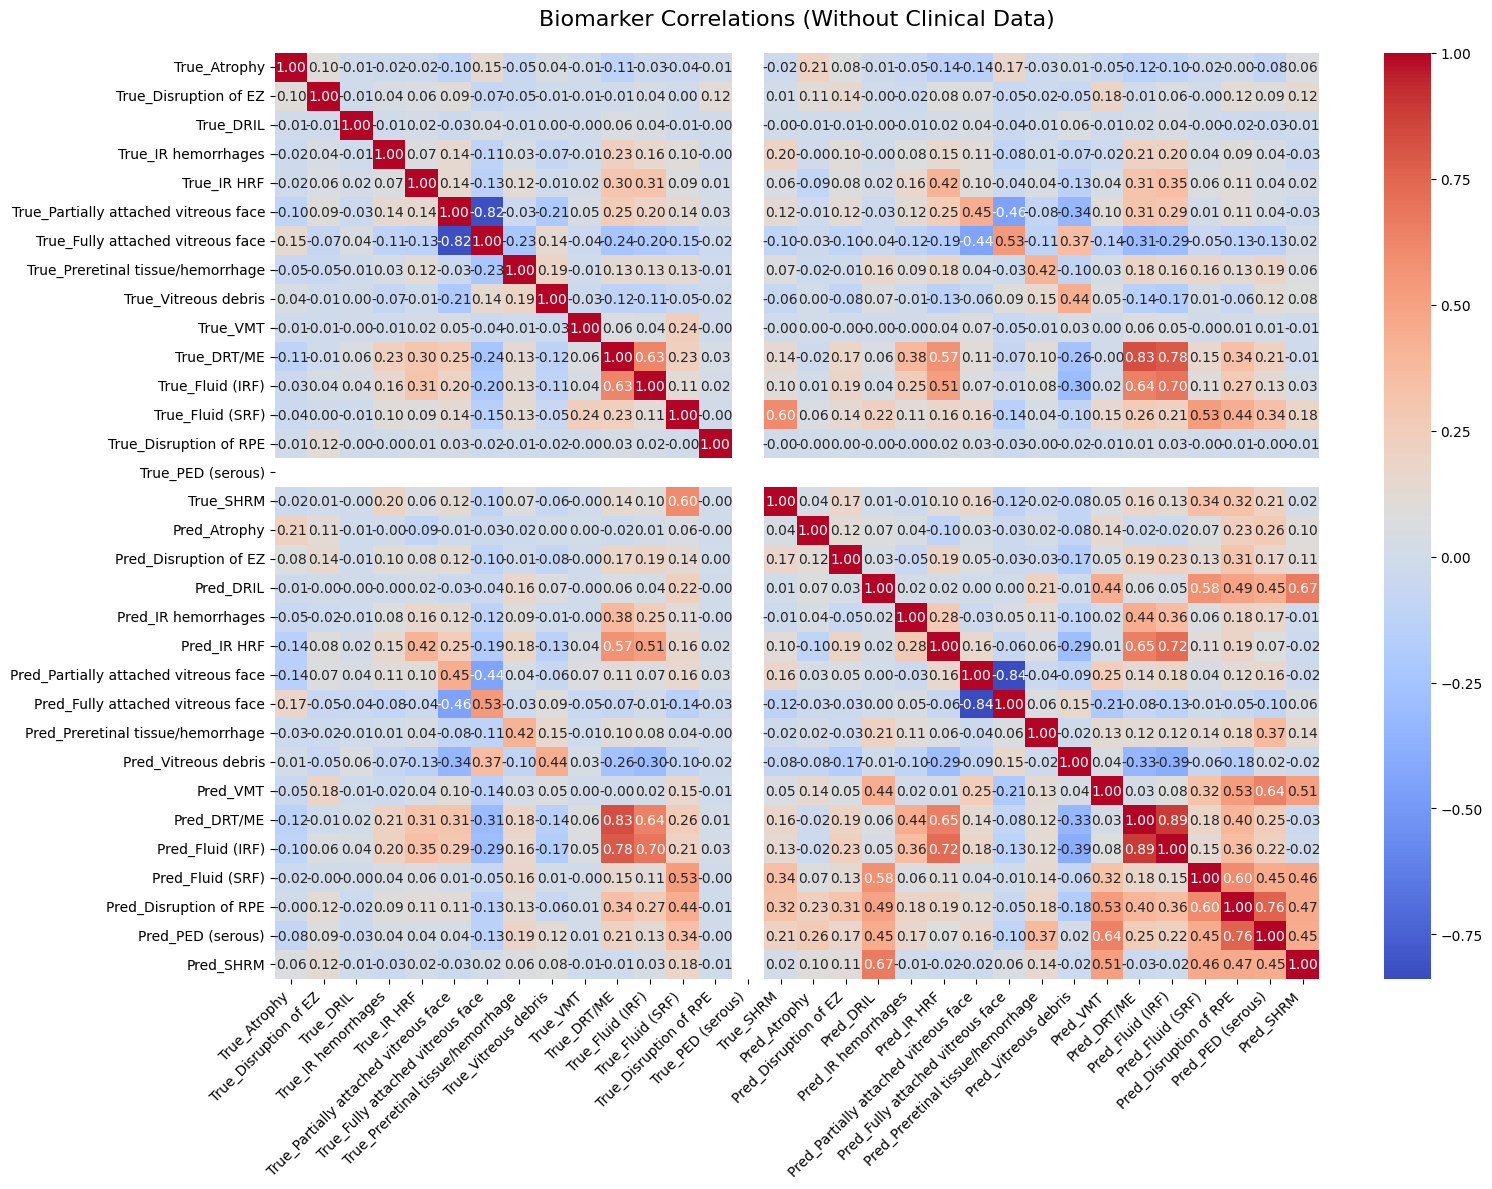

In [3]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def plot_biomarker_correlations(y_true, y_pred, labels, title):
    """
    Visualize biomarker correlations using ground truth and predictions.
    Args:
        y_true (ndarray): Ground truth labels (binary).
        y_pred (ndarray): Predicted probabilities.
        labels (list): Biomarker names.
        title (str): Title for the correlation matrix plot.
    """
    # Create DataFrames for true and predicted values
    true_df = pd.DataFrame(y_true, columns=[f"True_{label}" for label in labels])
    pred_df = pd.DataFrame(y_pred, columns=[f"Pred_{label}" for label in labels])
    
    # Concatenate the true and predicted data
    combined_df = pd.concat([true_df, pred_df], axis=1)

    # Compute the correlation matrix
    corr_matrix = combined_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 12))

    # Draw the heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        annot_kws={"size": 10},
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns
    )

    # Improve layout and appearance
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha="right")
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


# Step 1: Evaluate the model with clinical data
print("Evaluating Model with Clinical Data...")
y_true_clinical, y_pred_clinical, _ = evaluate_model(model_clinical, testloader_clinical, labels)

# Step 2: Evaluate the model without clinical data
print("Evaluating Model without Clinical Data...")
y_true_no_clinical, y_pred_no_clinical, _ = evaluate_model(model_no_clinical, testloader_no_clinical, labels)

# Step 3: Visualize biomarker correlations for clinical data
print("Visualizing biomarker correlations with clinical data...")
plot_biomarker_correlations(
    y_true_clinical, y_pred_clinical, labels, title="Biomarker Correlations (With Clinical Data)"
)

# Step 4: Visualize biomarker correlations for vision-only model
print("Visualizing biomarker correlations without clinical data...")
plot_biomarker_correlations(
    y_true_no_clinical, y_pred_no_clinical, labels, title="Biomarker Correlations (Without Clinical Data)"
)